# RQ1: AI framing analysis

This notebook analyses how artificial intelligence is framed in Swedish parliamentary documents, comparing bottom-up proposals (motioner) with top-down government bills (propositioner). We examine whether AI is presented primarily as an opportunity, a risk, or both.

## Setup and imports

In [1]:
import re
from pathlib import Path
from collections import defaultdict, Counter
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from nltk.sentiment import SentimentIntensityAnalyzer

# configure visualisation defaults
plt.rcParams['font.family'] = 'monospace'
plt.rcParams['font.size'] = 10
sns.set_palette(['#9b59b6', '#e91e63', '#34495e', '#95a5a6'])

## Data loading

Load all documents from both directories and parse their metadata headers to create a structured dataset.

In [2]:
def parse_document(filepath):
    """extract metadata and content from a parliamentary document file."""
    with open(filepath, 'r', encoding='utf-8') as f:
        content = f.read()
    
    # split header from content
    parts = content.split('=' * 80)
    if len(parts) < 2:
        return None
    
    header = parts[0]
    doc_content = parts[1].strip()
    
    # extract metadata fields
    metadata = {}
    for line in header.strip().split('\n'):
        if ':' in line:
            key, value = line.split(':', 1)
            metadata[key.strip().lower()] = value.strip()
    
    return {
        'doc_id': metadata.get('document id', ''),
        'title': metadata.get('title', ''),
        'date': metadata.get('date', ''),
        'year': metadata.get('parliamentary year', ''),
        'search_term': metadata.get('search term', ''),
        'content': doc_content,
        'filepath': str(filepath)
    }

In [3]:
# load motioner
mot_dir = Path('/Users/simon/Dropbox/wrk/active/research/riksdagen-data/swe-rd-ai/data/motioner')
mot_files = list(mot_dir.glob('*.txt'))
mot_docs = [parse_document(f) for f in mot_files]
mot_docs = [doc for doc in mot_docs if doc is not None]

for doc in mot_docs:
    doc['doc_type'] = 'mot'

# load propositioner
prop_dir = Path('/Users/simon/Dropbox/wrk/active/research/riksdagen-data/swe-rd-ai/data/propositioner')
prop_files = list(prop_dir.glob('*.txt'))
prop_docs = [parse_document(f) for f in prop_files]
prop_docs = [doc for doc in prop_docs if doc is not None]

for doc in prop_docs:
    doc['doc_type'] = 'prop'

# combine into dataframe
all_docs = mot_docs + prop_docs
df = pd.DataFrame(all_docs)

print(f"loaded {len(mot_docs)} motioner and {len(prop_docs)} propositioner")
print(f"total documents: {len(df)}")
df.head()

loaded 452 motioner and 700 propositioner
total documents: 1152


,doc_id,title,date,year,search_term,content,filepath,doc_type
0,hd023729,Internationellt samarbete i en utmanande tid,2025-10-07,2025/26,artificiell intelligens,<style><!-- \n @page Section1 { size:595.3pt 8...,/Users/simon/Dropbox/wrk/active/research/riksd...,mot
1,hd023645,"Utgiftsområde 9 Hälsovård, sjukvård och social...",2025-10-07,2025/26,AI,<style><!-- \n @page Section1 { size:595.3pt 8...,/Users/simon/Dropbox/wrk/active/research/riksd...,mot
2,hc02351,Pornografi och sexuell exploatering på nätet,2024-09-24,2024/25,AI,<style><!-- \n @page Section1 { size:595.3pt 8...,/Users/simon/Dropbox/wrk/active/research/riksd...,mot
3,ha021483,Användning av moderna tester för prostatacancer,2022-11-22,2022/23,AI,<style><!-- \n @page Section1 { size:595.3pt 8...,/Users/simon/Dropbox/wrk/active/research/riksd...,mot
4,h5022531,Utgiftsområde 24 Näringsliv,2017-10-04,2017/18,artificiell intelligens,<style><!-- \n /******************************...,/Users/simon/Dropbox/wrk/active/research/riksd...,mot


## Text preprocessing

Remove HTML tags and extract clean text for analysis.

In [4]:
def clean_html(html_text):
    """remove html tags and extract plain text."""
    soup = BeautifulSoup(html_text, 'html.parser')
    text = soup.get_text()
    # normalise whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['clean_text'] = df['content'].apply(clean_html)
df['word_count'] = df['clean_text'].apply(lambda x: len(x.split()))

print(f"average document length: {df['word_count'].mean():.0f} words")
df.groupby('doc_type')['word_count'].describe()

average document length: 52590 words


,count,mean,std,min,25%,50%,75%,max
doc_type,,,,,,,,
mot,452.0,6490.818584,8784.346010,133.0,777.25,3149.0,8230.75,55438.0
prop,700.0,82357.245714,101851.489997,2855.0,25444.25,53448.5,104145.75,1748186.0


## Dictionary-based framing analysis

Define Swedish word lists representing opportunity and risk frames, then count occurrences in each document.

In [5]:
# opportunity framing keywords
opportunity_words = [
    'möjlighet', 'potential', 'tillväxt', 'innovation', 'effektivitet',
    'konkurrenskraft', 'utveckling', 'framsteg', 'nytta', 'fördel',
    'förbättra', 'förbättring', 'modernisera', 'modernisering',
    'optimera', 'optimering', 'produktivitet', 'lösning', 'framtid',
    'tillgång', 'styrka', 'resurs', 'investering', 'satsning'
]

# risk framing keywords
risk_words = [
    'hot', 'risk', 'fara', 'arbetslöshet', 'integritet', 'övervakning',
    'ojämlikhet', 'etik', 'etisk', 'oro', 'utmaning', 'problem',
    'sårbarhet', 'sårbara', 'motverka', 'begränsa', 'begränsning',
    'skydda', 'skydd', 'kontroll', 'reglera', 'reglering',
    'missbruk', 'diskriminering', 'fördom', 'bias'
]

print(f"opportunity dictionary: {len(opportunity_words)} words")
print(f"risk dictionary: {len(risk_words)} words")

opportunity dictionary: 24 words
risk dictionary: 26 words


In [6]:
def count_framing_words(text, word_list):
    """count occurrences of framing words in text."""
    text_lower = text.lower()
    count = 0
    for word in word_list:
        # word boundary matching
        count += len(re.findall(r'\b' + word + r'\w*\b', text_lower))
    return count

# calculate framing scores
df['opp_count'] = df['clean_text'].apply(lambda x: count_framing_words(x, opportunity_words))
df['risk_count'] = df['clean_text'].apply(lambda x: count_framing_words(x, risk_words))

# normalise by document length (per 1000 words)
df['opp_per_1k'] = (df['opp_count'] / df['word_count']) * 1000
df['risk_per_1k'] = (df['risk_count'] / df['word_count']) * 1000

# calculate framing ratio (opp - risk, normalised)
df['framing_ratio'] = df['opp_per_1k'] - df['risk_per_1k']

df[['doc_id', 'doc_type', 'opp_count', 'risk_count', 'opp_per_1k', 'risk_per_1k', 'framing_ratio']].head()

,doc_id,doc_type,opp_count,risk_count,opp_per_1k,risk_per_1k,framing_ratio
0,hd023729,mot,91,67,5.927566,4.364252,1.563314
1,hd023645,mot,364,341,10.265666,9.617012,0.648655
2,hc02351,mot,3,5,7.317073,12.195122,-4.878049
3,ha021483,mot,5,3,12.135922,7.281553,4.854369
4,h5022531,mot,52,6,30.462800,3.514938,26.947862


## Framing comparison by document type

Compare the distribution of opportunity and risk framing between motioner and propositioner.

In [7]:
# summary statistics by document type
framing_summary = df.groupby('doc_type').agg({
    'opp_per_1k': ['mean', 'median', 'std'],
    'risk_per_1k': ['mean', 'median', 'std'],
    'framing_ratio': ['mean', 'median', 'std']
}).round(2)

framing_summary

opp_per_1k              risk_per_1k              framing_ratio  \
               mean median   std        mean median   std          mean   
doc_type                                                                  
mot           14.42  12.18  8.75        8.00   6.58  5.88          6.43   
prop           5.02   3.30  5.03        5.59   4.83  4.13         -0.57   

                        
         median    std  
doc_type                
mot        5.61  11.11  
prop      -0.86   6.52

/var/folders/b7/5gzdm8l547b6y0gxw292zm7r0000gn/T/ipykernel_47819/2874776898.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot(


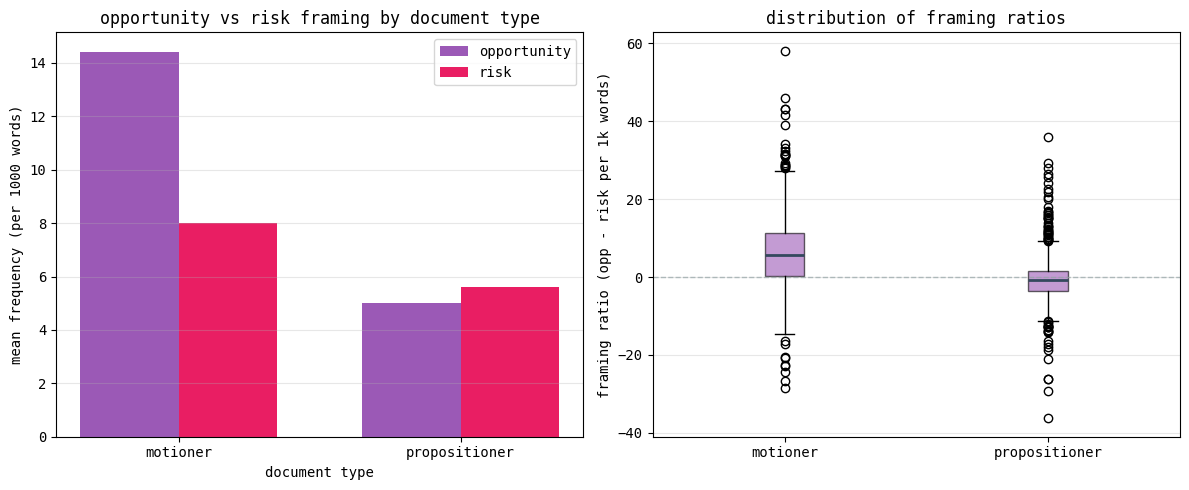

In [8]:
# visualisation: opportunity vs risk frequencies by document type
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# absolute counts
doc_types = ['mot', 'prop']
opp_means = [df[df['doc_type'] == dt]['opp_per_1k'].mean() for dt in doc_types]
risk_means = [df[df['doc_type'] == dt]['risk_per_1k'].mean() for dt in doc_types]

x = np.arange(len(doc_types))
width = 0.35

axes[0].bar(x - width/2, opp_means, width, label='opportunity', color='#9b59b6')
axes[0].bar(x + width/2, risk_means, width, label='risk', color='#e91e63')
axes[0].set_xlabel('document type')
axes[0].set_ylabel('mean frequency (per 1000 words)')
axes[0].set_title('opportunity vs risk framing by document type')
axes[0].set_xticks(x)
axes[0].set_xticklabels(['motioner', 'propositioner'])
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# framing ratio distribution
axes[1].boxplot(
    [df[df['doc_type'] == 'mot']['framing_ratio'], 
     df[df['doc_type'] == 'prop']['framing_ratio']],
    labels=['motioner', 'propositioner'],
    patch_artist=True,
    boxprops=dict(facecolor='#9b59b6', alpha=0.6),
    medianprops=dict(color='#34495e', linewidth=2)
)
axes[1].axhline(0, color='#95a5a6', linestyle='--', linewidth=1, alpha=0.7)
axes[1].set_ylabel('framing ratio (opp - risk per 1k words)')
axes[1].set_title('distribution of framing ratios')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Context window analysis

Extract text surrounding AI mentions and analyse sentiment in these contexts to understand how AI is discussed when explicitly referenced.

In [9]:
# ai search terms (case insensitive)
ai_patterns = [
    r'\bai\b',
    r'artificiell intelligens',
    r'artificiella intelligens'
]

def extract_ai_contexts(text, window=50):
    """extract text windows around ai mentions."""
    contexts = []
    text_lower = text.lower()
    
    for pattern in ai_patterns:
        for match in re.finditer(pattern, text_lower):
            start = max(0, match.start() - window)
            end = min(len(text), match.end() + window)
            context = text[start:end]
            contexts.append(context)
    
    return contexts

df['ai_contexts'] = df['clean_text'].apply(extract_ai_contexts)
df['ai_mention_count'] = df['ai_contexts'].apply(len)

print(f"total ai mentions: {df['ai_mention_count'].sum()}")
df.groupby('doc_type')['ai_mention_count'].describe()

total ai mentions: 4532


,count,mean,std,min,25%,50%,75%,max
doc_type,,,,,,,,
mot,452.0,6.500000,12.609344,0.0,1.0,2.0,6.0,118.0
prop,700.0,2.277143,13.063411,0.0,0.0,0.0,1.0,313.0


In [10]:
# sentiment analysis on context windows
# note: vader is trained on english; results should be interpreted cautiously
sia = SentimentIntensityAnalyzer()

def analyse_context_sentiment(contexts):
    """calculate average sentiment across all context windows."""
    if not contexts:
        return {'pos': 0, 'neg': 0, 'neu': 0, 'compound': 0}
    
    scores = [sia.polarity_scores(ctx) for ctx in contexts]
    avg_scores = {
        'pos': np.mean([s['pos'] for s in scores]),
        'neg': np.mean([s['neg'] for s in scores]),
        'neu': np.mean([s['neu'] for s in scores]),
        'compound': np.mean([s['compound'] for s in scores])
    }
    return avg_scores

df['context_sentiment'] = df['ai_contexts'].apply(analyse_context_sentiment)
df['sentiment_compound'] = df['context_sentiment'].apply(lambda x: x['compound'])
df['sentiment_pos'] = df['context_sentiment'].apply(lambda x: x['pos'])
df['sentiment_neg'] = df['context_sentiment'].apply(lambda x: x['neg'])

# filter documents with ai mentions for meaningful sentiment analysis
df_with_ai = df[df['ai_mention_count'] > 0]

print(f"documents with ai mentions: {len(df_with_ai)}")
df_with_ai.groupby('doc_type')[['sentiment_compound', 'sentiment_pos', 'sentiment_neg']].mean().round(3)

documents with ai mentions: 717


,sentiment_compound,sentiment_pos,sentiment_neg
doc_type,,,
mot,-0.001,0.006,0.007
prop,0.014,0.011,0.005


/var/folders/b7/5gzdm8l547b6y0gxw292zm7r0000gn/T/ipykernel_47819/1498209984.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


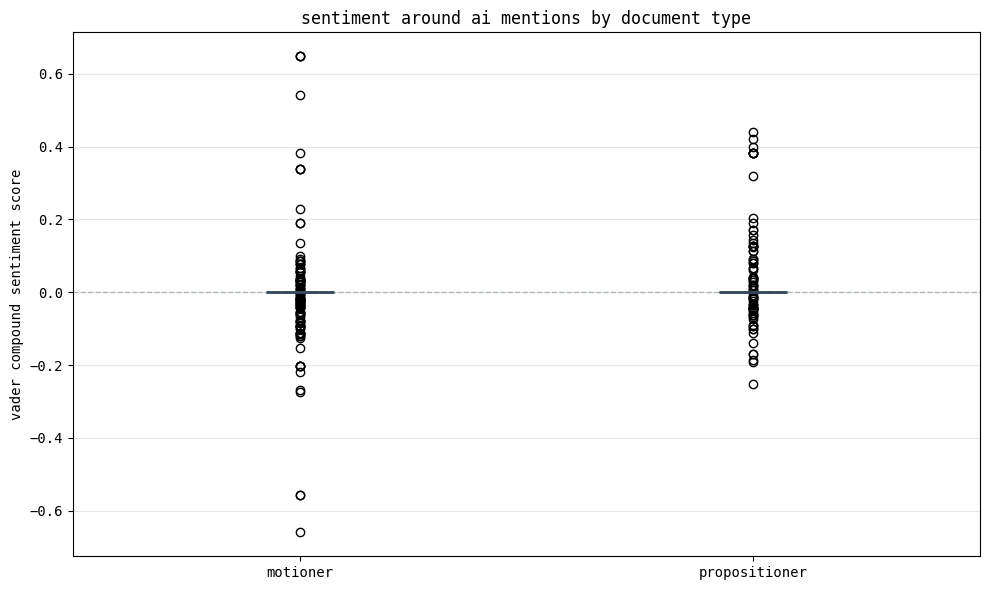

In [11]:
# visualisation: context sentiment by document type
fig, ax = plt.subplots(figsize=(10, 6))

ax.boxplot(
    [df_with_ai[df_with_ai['doc_type'] == 'mot']['sentiment_compound'],
     df_with_ai[df_with_ai['doc_type'] == 'prop']['sentiment_compound']],
    labels=['motioner', 'propositioner'],
    patch_artist=True,
    boxprops=dict(facecolor='#9b59b6', alpha=0.6),
    medianprops=dict(color='#34495e', linewidth=2)
)

ax.axhline(0, color='#95a5a6', linestyle='--', linewidth=1, alpha=0.7)
ax.set_ylabel('vader compound sentiment score')
ax.set_title('sentiment around ai mentions by document type')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Temporal analysis

Examine how AI framing has evolved over parliamentary years.

In [12]:
# aggregate by year and document type
temporal = df.groupby(['year', 'doc_type']).agg({
    'opp_per_1k': 'mean',
    'risk_per_1k': 'mean',
    'framing_ratio': 'mean',
    'doc_id': 'count'
}).rename(columns={'doc_id': 'n_docs'}).reset_index()

# filter years with sufficient documents
temporal = temporal[temporal['n_docs'] >= 5]

temporal.head(10)

,year,doc_type,opp_per_1k,risk_per_1k,framing_ratio,n_docs
0,1989/90,mot,10.290042,3.812855,6.477186,7
1,1989/90,prop,7.594487,2.725128,4.869359,5
3,1990/91,prop,6.240959,3.391611,2.849348,5
5,1991/92,prop,1.609851,2.817261,-1.207410,9
7,1992/93,prop,3.455999,2.958688,0.497311,10
10,1994/95,prop,3.550315,4.718541,-1.168226,8
12,1995/96,prop,5.011716,2.542282,2.469434,6
13,1996/97,prop,6.019657,3.175149,2.844508,6
19,2000/01,prop,10.412580,4.233494,6.179086,6
21,2001/02,prop,2.485103,4.246313,-1.761210,8


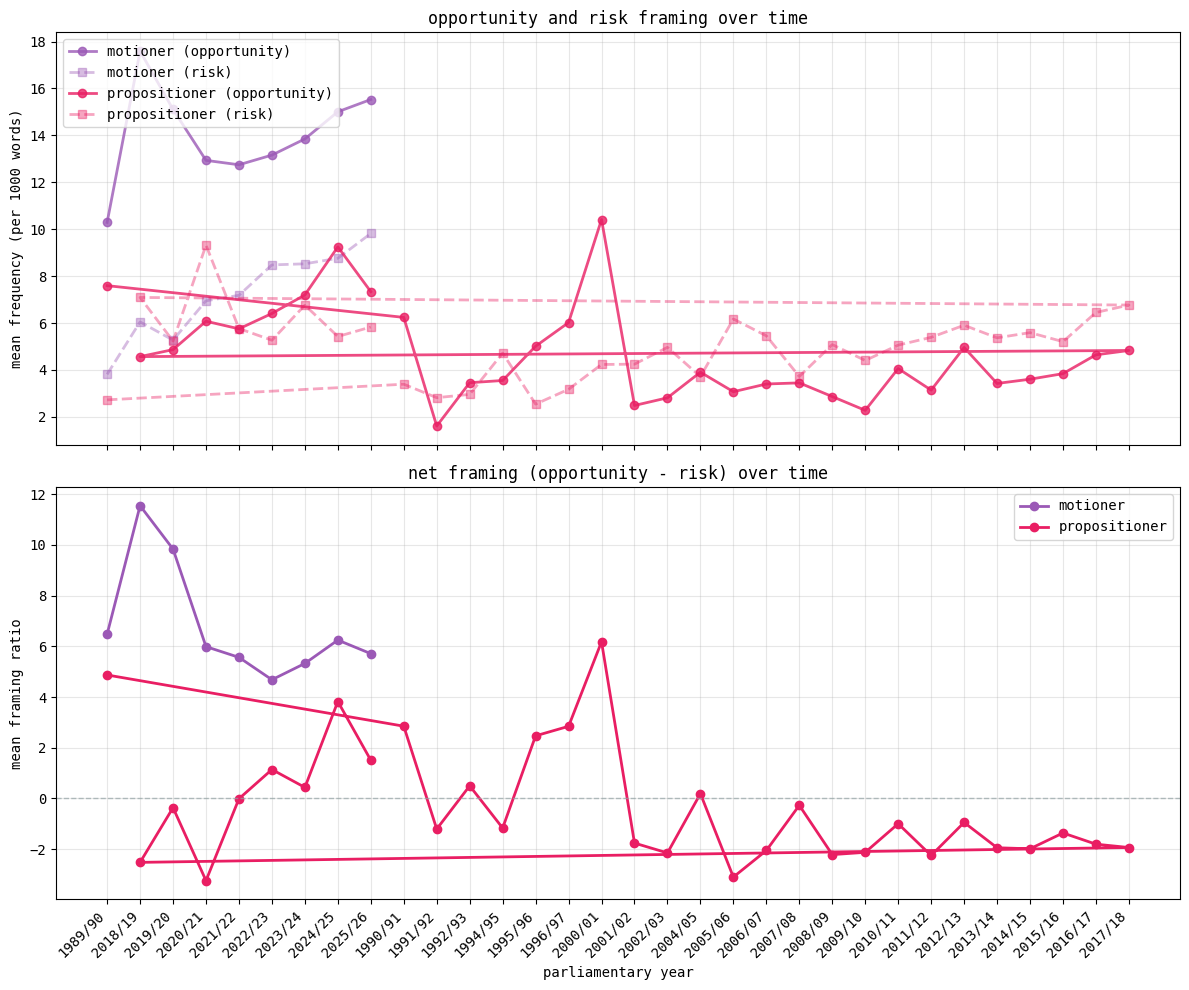

In [13]:
# visualisation: framing over time
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# opportunity vs risk trends
for doc_type, color in [('mot', '#9b59b6'), ('prop', '#e91e63')]:
    data = temporal[temporal['doc_type'] == doc_type].sort_values('year')
    label = 'motioner' if doc_type == 'mot' else 'propositioner'
    
    axes[0].plot(data['year'], data['opp_per_1k'], 
                marker='o', linewidth=2, color=color, alpha=0.8,
                label=f'{label} (opportunity)')
    axes[0].plot(data['year'], data['risk_per_1k'], 
                marker='s', linewidth=2, color=color, alpha=0.4, linestyle='--',
                label=f'{label} (risk)')

axes[0].set_ylabel('mean frequency (per 1000 words)')
axes[0].set_title('opportunity and risk framing over time')
axes[0].legend(loc='upper left')
axes[0].grid(alpha=0.3)

# framing ratio trends
for doc_type, color in [('mot', '#9b59b6'), ('prop', '#e91e63')]:
    data = temporal[temporal['doc_type'] == doc_type].sort_values('year')
    label = 'motioner' if doc_type == 'mot' else 'propositioner'
    
    axes[1].plot(data['year'], data['framing_ratio'], 
                marker='o', linewidth=2, color=color, label=label)

axes[1].axhline(0, color='#95a5a6', linestyle='--', linewidth=1, alpha=0.7)
axes[1].set_xlabel('parliamentary year')
axes[1].set_ylabel('mean framing ratio')
axes[1].set_title('net framing (opportunity - risk) over time')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Summary statistics and export

Generate final summary statistics and export results for further analysis.

In [14]:
# overall framing summary
print("=" * 60)
print("FRAMING ANALYSIS SUMMARY")
print("=" * 60)
print(f"\ntotal documents analysed: {len(df)}")
print(f"  - motioner: {len(df[df['doc_type'] == 'mot'])}")
print(f"  - propositioner: {len(df[df['doc_type'] == 'prop'])}")

print("\nopportunity framing (per 1000 words):")
for doc_type in ['mot', 'prop']:
    mean_val = df[df['doc_type'] == doc_type]['opp_per_1k'].mean()
    label = 'motioner' if doc_type == 'mot' else 'propositioner'
    print(f"  {label}: {mean_val:.2f}")

print("\nrisk framing (per 1000 words):")
for doc_type in ['mot', 'prop']:
    mean_val = df[df['doc_type'] == doc_type]['risk_per_1k'].mean()
    label = 'motioner' if doc_type == 'mot' else 'propositioner'
    print(f"  {label}: {mean_val:.2f}")

print("\nnet framing ratio (opp - risk):")
for doc_type in ['mot', 'prop']:
    mean_val = df[df['doc_type'] == doc_type]['framing_ratio'].mean()
    label = 'motioner' if doc_type == 'mot' else 'propositioner'
    print(f"  {label}: {mean_val:.2f}")

print("\ndocuments with ai mentions: {}".format(len(df_with_ai)))
print("\naverage context sentiment (vader compound):")
for doc_type in ['mot', 'prop']:
    mean_val = df_with_ai[df_with_ai['doc_type'] == doc_type]['sentiment_compound'].mean()
    label = 'motioner' if doc_type == 'mot' else 'propositioner'
    print(f"  {label}: {mean_val:.3f}")
print("=" * 60)

FRAMING ANALYSIS SUMMARY

total documents analysed: 1152
  - motioner: 452
  - propositioner: 700

opportunity framing (per 1000 words):
  motioner: 14.42
  propositioner: 5.02

risk framing (per 1000 words):
  motioner: 8.00
  propositioner: 5.59

net framing ratio (opp - risk):
  motioner: 6.43
  propositioner: -0.57

documents with ai mentions: 717

average context sentiment (vader compound):
  motioner: -0.001
  propositioner: 0.014


In [15]:
# export results
output_dir = Path('/Users/simon/Dropbox/wrk/active/research/riksdagen-data/swe-rd-ai/results')
output_dir.mkdir(exist_ok=True)

# save document-level results
export_cols = ['doc_id', 'doc_type', 'title', 'date', 'year', 'word_count',
               'opp_count', 'risk_count', 'opp_per_1k', 'risk_per_1k', 
               'framing_ratio', 'ai_mention_count', 'sentiment_compound']
df[export_cols].to_csv(output_dir / 'rq1_document_framing.csv', index=False)

# save temporal aggregates
temporal.to_csv(output_dir / 'rq1_temporal_framing.csv', index=False)

print(f"results exported to {output_dir}")

results exported to /Users/simon/Dropbox/wrk/active/research/riksdagen-data/swe-rd-ai/results
